In [1]:
!pip install -q tensorflow transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.layers import (
    GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional,
    SpatialDropout1D, Dense, Activation, Dropout, BatchNormalization,
    Embedding, LSTM, GRU
)
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanSquaredError
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences

from scipy.stats import pearsonr
from string import punctuation
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow_hub as tfh
from transformers import TFBertModel, BertTokenizer

In [3]:
df = pd.read_csv('ielts_writing_dataset.csv')

# Exploratory data analysis

In [4]:
print("Shape:", df.shape)
df.head(3)

Shape: (1435, 9)


,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,NaN,NaN,NaN,NaN,5.0


In [5]:
df.describe()

,Task_Type,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
count,1435.000000,0.0,0.0,0.0,0.0,1435.000000
mean,1.552613,NaN,NaN,NaN,NaN,6.550174
std,0.497397,NaN,NaN,NaN,NaN,1.058237
min,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,1.000000,NaN,NaN,NaN,NaN,6.000000
50%,2.000000,NaN,NaN,NaN,NaN,6.500000
75%,2.000000,NaN,NaN,NaN,NaN,7.000000
max,2.000000,NaN,NaN,NaN,NaN,9.000000


In [6]:
df = df.rename(columns={'Examiner_Commen': 'Comment'})

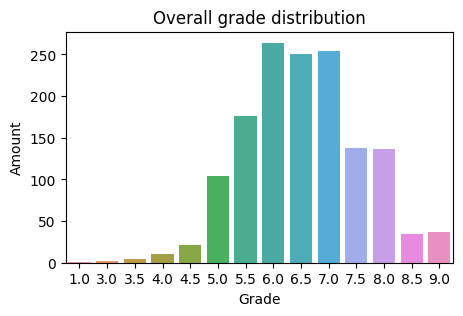

In [7]:
# Assuming 'column_name' is the name of the column you want to plot
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Overall')
plt.title(f'Overall grade distribution')
plt.xlabel('Grade')
plt.ylabel('Amount')
plt.show()


Let's drop the samples whose label appears only ones, so we are able to stratify it.

In [8]:
df = df[df['Overall'].map(df['Overall'].value_counts()) > 1]

Check for the amount of examiners comments, to decide if they are in a meaningful amount for training or not.


In [9]:
# Group by "Overall" and count non-None values in "Comment"
df[df['Comment'].notna()].groupby("Overall")["Comment"].count()

Overall
5.0     8
6.0    24
7.0    17
8.0    13
Name: Comment, dtype: int64

Check for the amount of questions not provided.

In [10]:
df['Question'].isna().sum()

0

##Feature engineering
Now we explore the correlation between the essay's length and the grade.

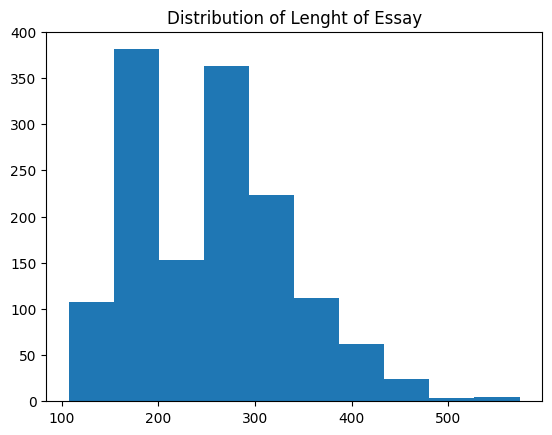

In [11]:
df["Length"]=df["Essay"].apply(lambda x: len(x.split(" ")))
plt.hist(df["Length"])
plt.title("Distribution of Lenght of Essay")
plt.show()

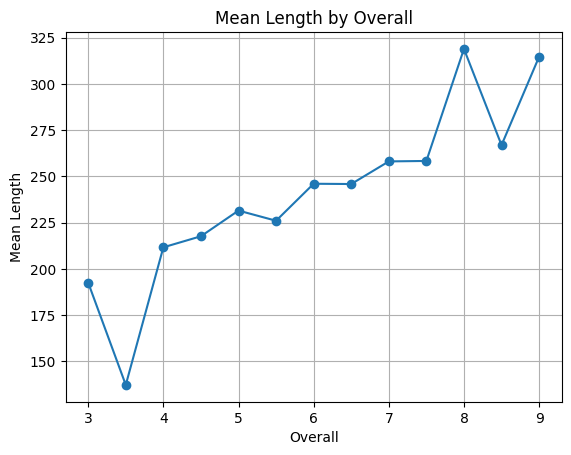

In [12]:
# Group by "Overall" and calculate the mean of "Length"
result = df.groupby(["Overall"]).agg({"Length":"mean"})

# Reset the index to make "Overall" a regular column
result.reset_index(inplace=True)

# Create a line plot
plt.plot(result["Overall"], result["Length"], marker='o', linestyle='-')
plt.xlabel("Overall")
plt.ylabel("Mean Length")
plt.title("Mean Length by Overall")
plt.grid(True)
plt.show()

In [13]:
# Transform the 'Category' column to 0s and 1s
df['Task_Type'] = (df['Task_Type'] == 2).astype(int)

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Task_Type'], prefix=['Task_Type'])

#Data preparation
After the data exploration decided to keep 3 data configurations:
1. BERT with only essay text (text)
2. BERT with essay text concatenated with length feature (text + numerical)
3. BERT with essay text concatenated with length and task type (text + numerical + binary)

3rd option is not preferable for deployment because user must choose also the task number => less user friendly.

The Question data are dropped because it would be harder for a user to insert also a quesion text to the website.

In [14]:
# All changeable variables are stored in a config dictionary for easier access
config ={
    "max_seq_length": 512,
    "bert_model_name": "bert-base-uncased",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "loss": 'mean_squared_error',
    "metrics": [MeanAbsoluteError(), RootMeanSquaredError()],
}

In [15]:
# Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(config['bert_model_name'])
bert_model = TFBertModel.from_pretrained(config['bert_model_name'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [16]:
# Extract chosen data
X = df[['Essay',
        'Length',
        'Task_Type_0',
        'Task_Type_1']]

y = df['Overall']

# Define the indexes for different feature types
text_colums_indexes = 0
numerical_columns_indexes = [1]
binary_columns_indexes = [2, 3]

In [17]:
# Separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X.values, y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=42
)

In [18]:
# Extract features
text_features_train = X_train[:, text_colums_indexes]
text_features_val = X_val[:, text_colums_indexes]

numerical_features_train = X_train[:, numerical_columns_indexes]
numerical_features_val = X_val[:, numerical_columns_indexes]

binary_features_train = X_train[:, binary_columns_indexes]
binary_features_val = X_val[:, binary_columns_indexes]

In [19]:
# Tokenize the text features with padding and truncation
input_ids_train = bert_tokenizer(list(text_features_train), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']
input_ids_val = bert_tokenizer(list(text_features_val), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']

In [20]:
# Standartize the numerical data
scaler = StandardScaler()
numerical_features_train_std = scaler.fit_transform(numerical_features_train)
numerical_features_val_std = scaler.transform(numerical_features_val)

In [21]:
# Gather all the features to one dictionary
X_train_dict = {
    "input_ids": input_ids_train,
    "numerical_features": numerical_features_train_std.astype(np.float32),
    "binary_features": binary_features_train.astype(np.float32)
}

X_val_dict = {
    "input_ids": input_ids_val,
    "numerical_features": numerical_features_val_std.astype(np.float32),
    "binary_features": binary_features_val.astype(np.float32)
}

# Defining the models

### 1st model type:
- Text

In [22]:
# Create a custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

# Combine BERT and Regression Head
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32)
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output
regression_output = regression_head(pooler_output)  # Custom regression head

bert_text_model = tf.keras.models.Model(inputs=input_ids, outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model, specifying the loss and metrics
bert_text_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_text_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 512, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                             

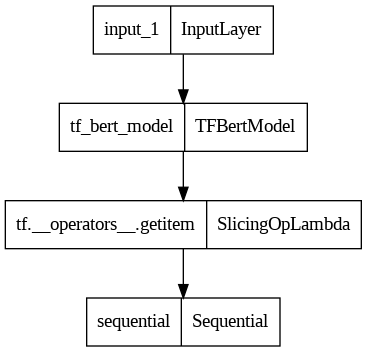

In [23]:
tf.keras.utils.plot_model(bert_text_model)

### 2nd model type:
- Text
- Numerical

In [24]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="numerical_features")

# BERT embedding layer
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]    # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_num_model = tf.keras.models.Model(inputs=[input_ids, numerical_features], outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_num_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_num_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 )                           ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                     

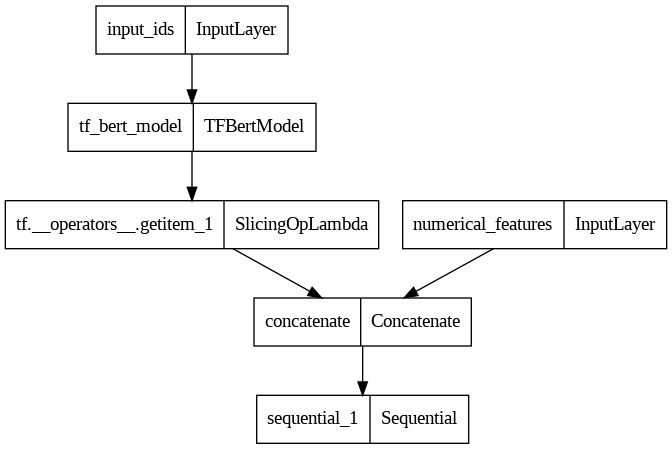

In [25]:
tf.keras.utils.plot_model(bert_num_model)

### 3rd model type:
- Text
- Numerical
- Binary

In [26]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name="numerical_features")
binary_features = tf.keras.layers.Input(shape=(2,), dtype=tf.float32, name="binary_features")

# BERT embedding layer
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features, binary_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_num_binary_model = tf.keras.models.Model(inputs=[input_ids, numerical_features, binary_features], outputs=regression_output)

# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_num_binary_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
    loss=config['loss'],
    metrics=config['metrics'])

# Print model summary
bert_num_binary_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 )                           ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                     

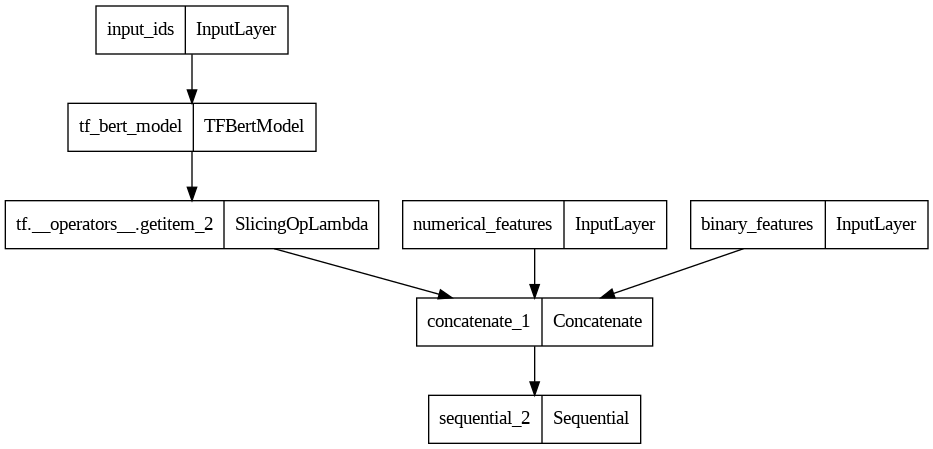

In [27]:
tf.keras.utils.plot_model(bert_num_binary_model)

# Training

In [28]:
# Define a callback to perform early stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0,         # Minimum change in validation loss to be considered an improvement
    patience=3,          # Number of epochs with no improvement after which training will stop
    verbose=0,           # Verbosity mode (0 for silent)
    mode='auto'          # Automatically infer the direction of loss improvement
)

In [42]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert = tf.keras.callbacks.ModelCheckpoint(
    filepath='training_bert_text/cp.ckpt',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert = bert_text_model.fit(X_train_dict['input_ids'], y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_val_dict['input_ids'], y_val),
    callbacks=[checkpoint_callback_bert, earlystop_callback])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 1.9972 - mean_absolute_error: 1.1344 - root_mean_squared_error: 1.4132
Epoch 1: val_loss improved from inf to 0.81007, saving model to training_bert_text/cp.ckpt
36/36 [==============================] - 113s 3s/step - loss: 1.9972 - mean_absolute_error: 1.1344 - root_mean_squared_error: 1.4132 - val_loss: 0.8101 - val_mean_absolute_error: 0.7148 - val_root_mean_squared_error: 0.9000
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 2.0780 - mean_absolute_error: 1.1436 - root_mean_squared_error: 1.4415
Epoch 2: val_loss improved from 0.81007 to 0.75920, saving model to training_bert_text/cp.ckpt
36/36 [==============================] - 115s 3s/step - loss: 2.0780 - mean_absolute_error: 1.1436 - root_mean_squared_error: 1.4415 - val_loss: 0.7592 - val_mean_absolute_error: 0.6898 - val_root_mean_squared_error: 0.8713
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 1.8828 - mean_absolu

In [30]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert_num = tf.keras.callbacks.ModelCheckpoint(
    filepath='training_bert_num/cp.ckpt',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert_num = bert_num_model.fit([X_train_dict['input_ids'], X_train_dict['numerical_features']], y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=([X_val_dict['input_ids'], X_val_dict['numerical_features']], y_val),
    callbacks=[checkpoint_callback_bert_num, earlystop_callback])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 7.8071 - mean_absolute_error: 1.8981 - root_mean_squared_error: 2.5350
Epoch 1: val_loss improved from inf to 1.07423, saving model to training_bert_num/cp.ckpt
36/36 [==============================] - 134s 3s/step - loss: 7.8071 - mean_absolute_error: 1.8981 - root_mean_squared_error: 2.5350 - val_loss: 1.0742 - val_mean_absolute_error: 0.8091 - val_root_mean_squared_error: 1.0364
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 3.1304 - mean_absolute_error: 1.4236 - root_mean_squared_error: 1.7693
Epoch 2: val_loss did not improve from 1.07423
36/36 [==============================] - 77s 2s/step - loss: 3.1304 - mean_absolute_error: 1.4236 - root_mean_squared_error: 1.7693 - val_loss: 1.0776 - val_mean_absolute_error: 0.8292 - val_root_mean_squared_error: 1.0381
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 2.7960 - mean_absolute_error: 1.3317 - root_mean_squared_error: 1.6721

In [31]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_bert_num_bin = tf.keras.callbacks.ModelCheckpoint(
    filepath='training_bert_num_bin/cp.ckpt',  # Specify the path to save the best model
    monitor='val_loss',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=1                 # Verbosity mode (0 for silent)
)

history_bert_num_bin = bert_num_binary_model.fit([X_train_dict['input_ids'], X_train_dict['numerical_features'], X_train_dict['binary_features']],
    y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_val_dict, y_val),
    callbacks=[checkpoint_callback_bert_num_bin, earlystop_callback])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 5.6229 - mean_absolute_error: 1.6309 - root_mean_squared_error: 2.1615
Epoch 1: val_loss improved from inf to 0.99717, saving model to training_bert_num_bin/cp.ckpt
36/36 [==============================] - 128s 3s/step - loss: 5.6229 - mean_absolute_error: 1.6309 - root_mean_squared_error: 2.1615 - val_loss: 0.9972 - val_mean_absolute_error: 0.7969 - val_root_mean_squared_error: 0.9986
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 2.4028 - mean_absolute_error: 1.2370 - root_mean_squared_error: 1.5501
Epoch 2: val_loss improved from 0.99717 to 0.91668, saving model to training_bert_num_bin/cp.ckpt
36/36 [==============================] - 109s 3s/step - loss: 2.4028 - mean_absolute_error: 1.2370 - root_mean_squared_error: 1.5501 - val_loss: 0.9167 - val_mean_absolute_error: 0.7721 - val_root_mean_squared_error: 0.9574
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 1.9783 - mean_

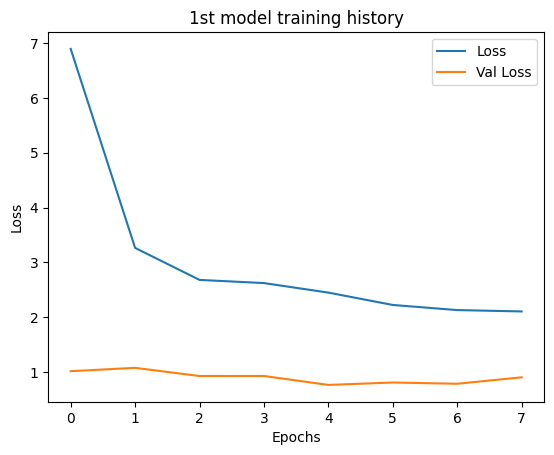

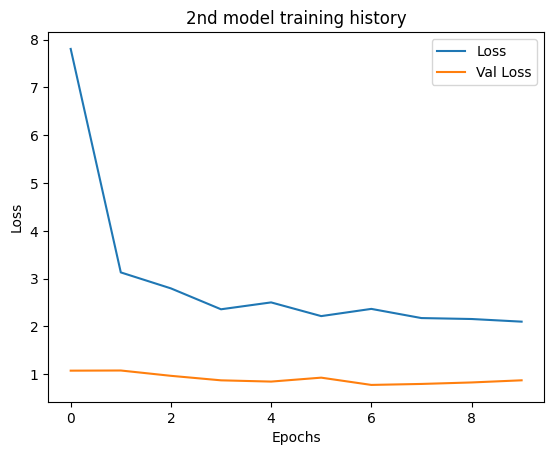

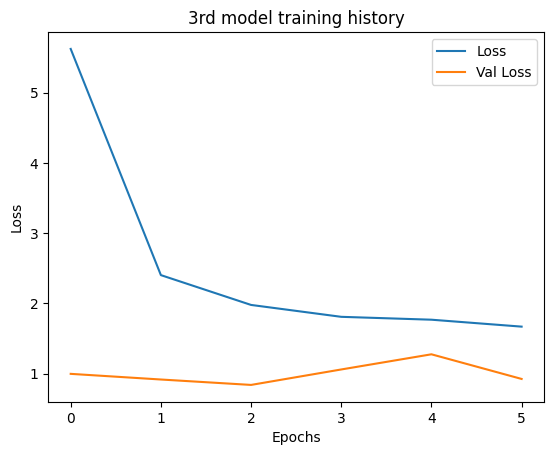

In [32]:
# 1st model
plt.plot(history_bert.history["loss"])
plt.plot(history_bert.history["val_loss"])
plt.title("1st model training history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])
plt.show()

# 2nd model
plt.plot(history_bert_num.history["loss"])
plt.plot(history_bert_num.history["val_loss"])
plt.title("2nd model training history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])
plt.show()

# 3rd model
plt.plot(history_bert_num_bin.history["loss"])
plt.plot(history_bert_num_bin.history["val_loss"])
plt.title("3rd model training history")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])
plt.show()

# Results and conclusions

In [49]:
bert_text_model.load_weights('training_bert_text/cp.ckpt')
bert_num_model.load_weights('training_bert_num/cp.ckpt')
bert_num_binary_model.load_weights('training_bert_num_bin/cp.ckpt')

In [50]:
predictions_bert_text = bert_text_model.predict(X_val_dict['input_ids'])
bert_text_mae = mean_absolute_error(y_val, predictions_bert_text)
print(bert_text_mae)

9/9 [==============================] - 11s 1s/step
0.6897830348396966


In [51]:
predictions_bert_num = bert_num_model.predict([X_val_dict['input_ids'], X_val_dict['numerical_features']])
bert_num_mae = mean_absolute_error(y_val, predictions_bert_num)
print(bert_num_mae)

9/9 [==============================] - 11s 1s/step
0.7178799615919798


In [52]:
predictions_bert_num_bin = bert_num_binary_model.predict([X_val_dict['input_ids'], X_val_dict['numerical_features'], X_val_dict['binary_features']])
bert_num_bin_mae = mean_absolute_error(y_val, predictions_bert_num_bin)
print(bert_num_bin_mae)

9/9 [==============================] - 11s 1s/step
0.7327360924112672


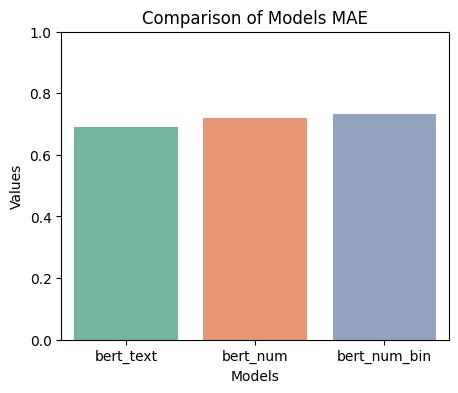

In [53]:
# Create a data frame for the metrics and values
mae_results = pd.DataFrame({'Models': ['bert_text', 'bert_num', 'bert_num_bin'],
                     'Values': [bert_text_mae, bert_num_mae, bert_num_bin_mae]})

# Create a bar plot using Seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x='Models', y='Values', data=mae_results, palette='Set2')
plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Comparison of Models MAE')

plt.ylim(0, 1)  # Set the y-axis range as needed
plt.show()